In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
DATA_DIR = '../../datasets/'

df = pd.read_csv(f'{DATA_DIR}tokenized/blog_authorship_tokenized.csv', usecols=['text', 'tokenized', 'gender'])
df.sample(5)

,text,gender,tokenized
159100,BLOGGING ZE OSCARS (PART III) Lord of the Ring...,male,blogging ze oscars ( part iii ) lord of the ri...
290189,I got a new job yesterday. This one is suppose...,male,i got a new job yesterday . this one is suppos...
560793,"In Bihar, even horses have castes ' We decide...",male,"in bihar , even horses have castes ' we deci..."
161602,*** When XX gave me a ride across the bridge I...,female,* * * when xx gave me a ride across the bridge...
303672,"Well, it's been a long time since I've bothere...",female,"well , it 's been a long time since i 've both..."


In [3]:
df['gender'].value_counts(dropna=False)

male      322357
female    313242
Name: gender, dtype: int64

In [4]:
df_ = df.copy()
df_ = df_.dropna()
print(df_.shape)

(635599, 3)


In [5]:
enc = LabelEncoder()
enc.fit(df_['gender'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df_['gender'] = enc.transform(df_['gender'])
encoded_labels

{'female': 0, 'male': 1}

In [6]:
X = df_['text']
y = df_['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=97)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((508479,), (127120,), (508479,), (127120,))

In [7]:
vect = TfidfVectorizer()
svm = LinearSVC()

pipe = make_pipeline(vect, svm)

In [8]:
param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1)],
    'linearsvc__random_state': [97],
}

In [9]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'linearsvc__random_state': 97, 'tfidfvectorizer__ngram_range': (1, 1)}


In [10]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.72      0.73     62503
           1       0.73      0.74      0.74     64617

    accuracy                           0.73    127120
   macro avg       0.73      0.73      0.73    127120
weighted avg       0.73      0.73      0.73    127120



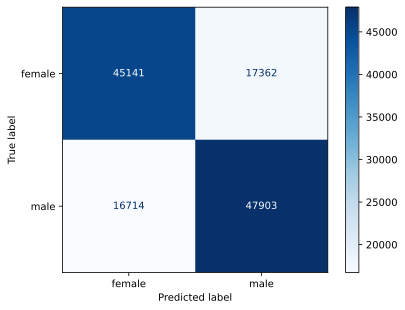

In [11]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues');

In [12]:
import joblib

joblib.dump(gs, 'gender_baseline.joblib')

['gender_baseline.joblib']

## Test the model

In [14]:
model = joblib.load('gender_baseline.joblib')

def predict_gender(text):
    classes = encoded_labels
    classes = {v: k for k, v in classes.items()} # reverse the dict
    return classes[model.predict([text])[0]]

In [15]:
predict_gender("Thanks to the best teams ever for making it possible!") # Male -> Correct

'male'

In [16]:
predict_gender("First time I got involved in a challenge was on 31-12-16 I took me almost 3 years, but I completed all the challenges") # Female -> Wrong

'male'

In [19]:
predict_gender("GM, and have a beautiful week everyone!") # Female -> Correct

'female'

In [20]:
predict_gender("I welcome the opportunity to meet the EU fishing sector in person and answer their questions about our EU Implementing Act on vulnerable marine ecosystems today.") # Male -> Correct

'male'

## *N*-gram features

In [7]:
from tempfile import mkdtemp
from shutil import rmtree

In [8]:
cache_dir = mkdtemp()

pipe = Pipeline(
    [
        ('vect', TfidfVectorizer()),
        ('clf', LinearSVC(random_state=97))
    ],
    memory=cache_dir
)

In [11]:
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__analyzer': ['word', 'char'],
}

In [12]:
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\dimboump\workspace\clips-internship\venv\lib\site-packages\sklearn\pipeline.py:336: UserWarning: Persisting input arguments took 302.56s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


{'clf__random_state': 97, 'vect__analyzer': 'word', 'vect__ngram_range': (1, 3)}


In [13]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73     62503
           1       0.74      0.74      0.74     64617

    accuracy                           0.74    127120
   macro avg       0.74      0.74      0.74    127120
weighted avg       0.74      0.74      0.74    127120



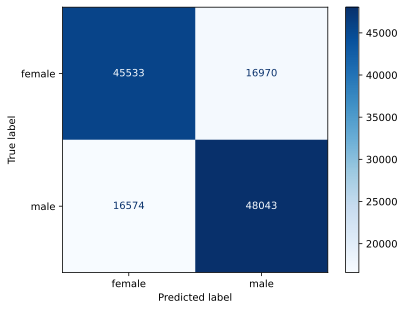

In [14]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues');

In [15]:
import joblib

joblib.dump(gs, 'gender_ngram.joblib')

['gender_ngram.joblib']

In [16]:
rmtree(cache_dir)